In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Get to know the data

In [3]:
gas = pd.read_csv('D:/download/Nat_Gas.csv')

In [7]:
gas = pd.DataFrame(gas)

dateFormat = '%m/%d/%y'
gas['Dates'] = pd.to_datetime(gas['Dates'], format=dateFormat)
gas = gas.set_index('Dates')
gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


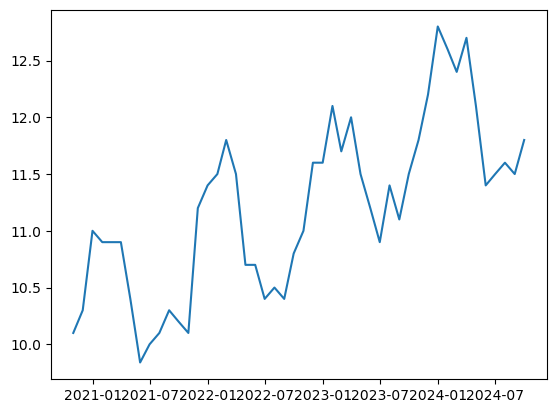

In [8]:
#1. load and visualize the data
plt.plot(gas)

from the above graph, it is easily to see the seasonality of the time seies data with an increasing trend, thus the following analysis and prediction will aim at the seasonality with increasing trend. 

With such an obvious but not constant seasonality, to better understand the patterns, first consider decomposition the data. 

### Decomposition

Methods of decomposition: 
1. Additive model
    - seasoanl variations are roughly constant over time
    - formula: 
        $Y_t = T_t + S_t + e_t$
        - $Y_t$ : observed data time t
        - $T_t$ : Trend component time t
        - $S_t$ : Seasonal componenet time t
        - $e_t$ : Residual component time t
2. Multiplicative Model
    - seasonal variation change poroportionally with the level of the series 
    - formula: 
        $Y_t = T_t \times S_t \times e_t$
3. STL Decomposition (Seasonal-Trend Decomposition using Loess(Locally Estimated Scatterplot Smoothing))
    - flexible and can handle complex seasonal patterns
    - Components: 
        - Seasonal Component: captures periodic fluctuations
        - Trend Componenet: captures the long-term progression of the series
        - residual component: captures the noise or irregular patterns
    - STL can handle both additive and multiplicative seasonality

Choose STL here as obseved complex patterns from the time seies data. 

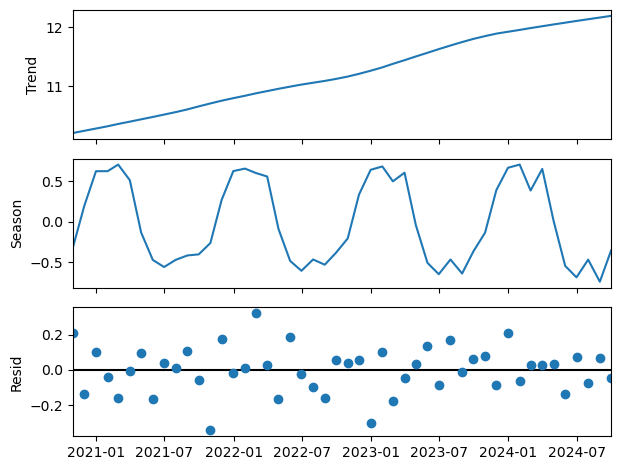

In [9]:
#2. decompose using stl
stl = STL(gas['Prices'],seasonal=13)
# The STL implementation in statsmodels requires the seasonal parameter to be an odd integer greater than or equal to 3. 
# This is a specific requirement for the LOESS-based decomposition method.
# In most cases, for monthly data, we'd expect a seasonality of 12. 
# However, since STL requires it to be odd, thus seasonal = 13

result = stl.fit()

fig = result.plot(observed=False, resid=True)
plt.show()

The plots shows the non-stationarity and seasonality of the data. To futher analysis and verify this observation, I would like to conduct the stationary test. 

In [10]:
gas.index.freq = 'ME'

### Stationary test
I choose the Augmented Dickey-Fuller (ADF) test. 
ADF test is used to test the null hypothesis that a unit root is presednt in a time series sample. It is a widely used methods and it is straightforard to implement. It is accounting for higher-order autoregressive process, and includes lagged difference terms to handle serial correlation. 

Other methods of stationary test: 

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:

Purpose: To test the null hypothesis that an observable time series is stationary around a deterministic trend (or level stationary).
Why Choose KPSS: It is a complementary test to the ADF. While the ADF test has the null hypothesis of non-stationarity, the KPSS test has the null hypothesis of stationarity. Using both tests together provides a more comprehensive view of the stationarity of the series.

Phillips-Perron (PP) Test:

Purpose: To test the null hypothesis of a unit root in a time series. It is similar to the ADF test but makes different assumptions about the nature of the error term.
Why Choose PP: It is non-parametric and robust to general forms of heteroskedasticity in the error term.

Dickey-Fuller GLS (DF-GLS) Test:

Purpose: A modified version of the ADF test that uses Generalized Least Squares (GLS) detrending.
Why Choose DF-GLS: It has better power properties than the standard ADF test.

In [17]:
result_stationary = adfuller(gas.index.to_series())
print('ADF Statistic:', result_stationary[0])
print('p-value:', result_stationary[1])
print('Critical Values:', result_stationary[4])

ADF Statistic: 0.6616758001298779
p-value: 0.9890411772696724
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}


The stationary test gives the following results:
1. the ADF statistic is higher than every critical values calculated, confirms the non-stationarity of the data.
2. p-value is higher than 0.05, thus fail to reject the null hypothesis. 

Both indicates the time series is non-stationary. 

### Make the data stationary

as the data is non-stationary as well as seasonal, the trend and the seasonality need to be removed. 

In [32]:
# Differencing to remove trend and seasonality
diff_series = gas.iloc[:, 0].diff().dropna()
seasonal_diff_series = diff_series.diff(7).dropna()

In [33]:
# ADF test on differenced series
result_stationary_diff = adfuller(seasonal_diff_series)


# ADF test results
print('ADF Statistic (differenced):', result_stationary_diff[0])
print('p-value (differenced):', result_stationary_diff[1])
print('Critical Values (differenced):', result_stationary_diff[4])

ADF Statistic (differenced): -5.236781574608493
p-value (differenced): 7.392576450511622e-06
Critical Values (differenced): {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.621171111111111}


The ADF test and the p-value indicate the rejection of the null hypothesis. 
The data is stationary now. 

Process to fit the ARIMA model. 

### ARIMA

ARMA for stationary time series, ARIMA is good for non-stationary time series: The "I" in ARIMA stands for "integrated" and refers to the number of differences applied to transform the series into a stationary one. 

Stationarity is a requirement for many time series forecasting methods. AR(auto regressive) MA(moving average)
ARIMA(1,1,1) order as a commonly used starting point for many time series, especially when there's no pronounced seasonality or when the seasonality has been removed or adjusted for. In practice, model selection should involve a more rigorous process:

1. Examine the ACF and PACF plots.
2. Fit multiple models with different orders.
3. Compare the models using criteria like the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC).
    - AIC & BIC help in comparing different models and selecting the one that best fits the data without overfitting
    - AIC & BIC provide a trade-off between the goodness of fit of the model and its complexity. The more complex models can fit the data better but might overfit, leading to poor generalization to new data. 
4. Validate the chosen model using out-of-sample predictions, if possible.

#### ACF & PACF

use ACF and PACF to determine parameters p, d, q in the ARIMA model

Forecast

a. Model and forecast the residuals using ARIMA.

b. Combine the forecasted trend, known seasonality, and forecasted residuals to obtain the final forecast.

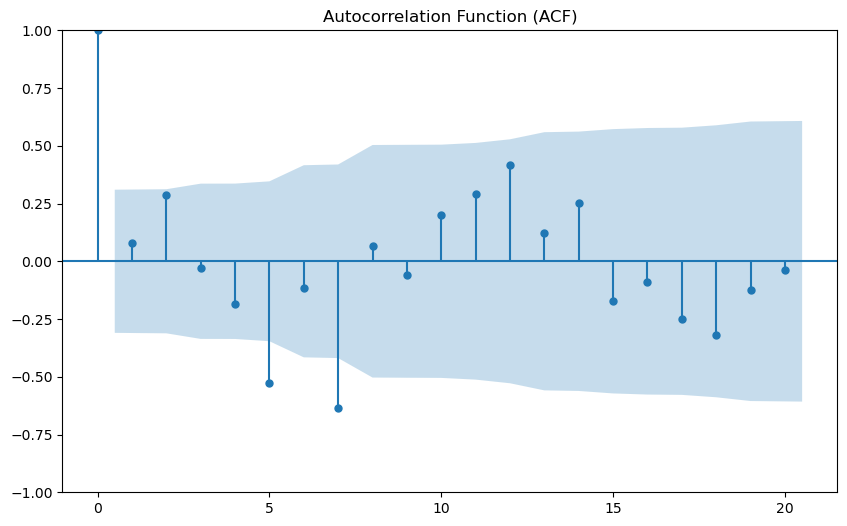

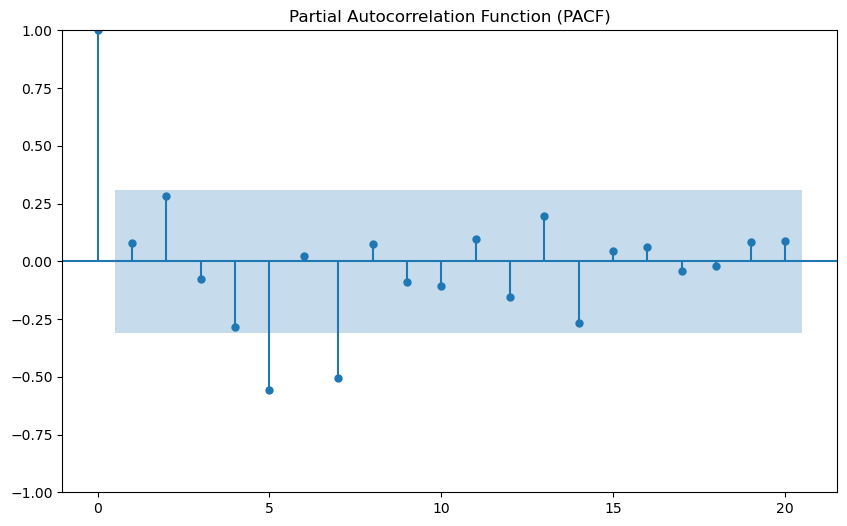

In [35]:
%matplotlib inline

plt.clf()
plt.close()

#plot_acf(result.resid.dropna(), lags=20)

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(seasonal_diff_series, lags=20, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF for completeness
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(seasonal_diff_series, lags=20, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

ACF plot: significant spike at lag 1, then decreases, indicates significant MA component. 
PACF plot: sigfinicatn spike at lag 1, then subsequent lags mostly within the confidence interval, suggests an AR(1) process. 

ARIMA: 
1. p(AR) order = 1, PACF plot shows significant spike at lag 1, subsequent lags not significant, thus p = 1. 
2. d(differencing order) = 1, the time series data has been differenced and now it is stationary, thus d = 1.
3. q(MA order) = 1, ACF plot shows a significatn spike at lag 1, then decreases, indicates an MA(1) process, thus q = 1

In [68]:
trend = ARIMA(result.trend.dropna(), order=(1,2,1))
trendFit = trend.fit()
forecastPeriods = 14
trendForecast = trendFit.forecast(steps = forecastPeriods)

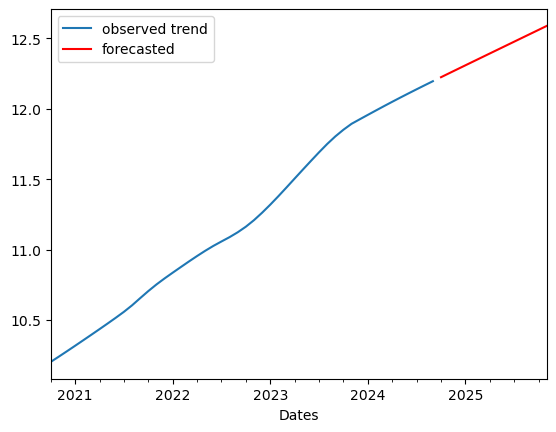

In [69]:
result.trend.plot(label = 'observed trend')
trendForecast.plot(label = 'forecasted', color = 'red')

plt.legend()
plt.show()

In [73]:
# Model and forecast the residuals
resModel = ARIMA(result.resid.dropna(), order=(1,1,1))
resFit = resModel.fit()
resForecast = resFit.forecast(steps = forecastPeriods)

In [72]:
forecast_index = pd.date_range(start=gas.index[-1] + pd.Timedelta(days=30), periods=forecastPeriods, freq='ME' )

trendForecast.index = forecast_index
resForecast.index = forecast_index
seasonalForecast = result.seasonal.tail(forecastPeriods)
seasonalForecast.index = forecast_index

# combine the forecasted trend, known seasonality and forecasted residuals
forecastTol = trendForecast + seasonalForecast + resForecast

In [62]:
{
    'trendForecast': trendForecast.values,
    'seasonality': result.seasonal.tail(forecastPeriods).values,
    'resForecast': resForecast.values, 
    'final': forecastTol.values
}

{'trendForecast': array([12.22458805, 12.25283562, 12.28099151, 12.30908399, 12.33713261,
        12.3651509 , 12.39314821, 12.42113101, 12.44910377, 12.47706959,
        12.5050306 , 12.53298829]),
 'seasonality': array([-0.13295403,  0.39039564,  0.66530816,  0.70422968,  0.38503784,
         0.65104295,  0.0142226 , -0.54231807, -0.68236394, -0.4649035 ,
        -0.73629006, -0.35155912]),
 'resForecast': array([ 1.55095940e-02, -4.54189708e-03,  2.14149433e-03, -8.61564993e-05,
         6.56345011e-04,  4.08860762e-04,  4.91350094e-04,  4.63855456e-04,
         4.73019733e-04,  4.69965175e-04,  4.70983294e-04,  4.70643943e-04]),
 'final': array([12.10714361, 12.63868937, 12.94844116, 13.01322751, 12.7228268 ,
        13.01660271, 12.40786216, 11.8792768 , 11.76721285, 12.01263605,
        11.76921153, 12.18189982])}

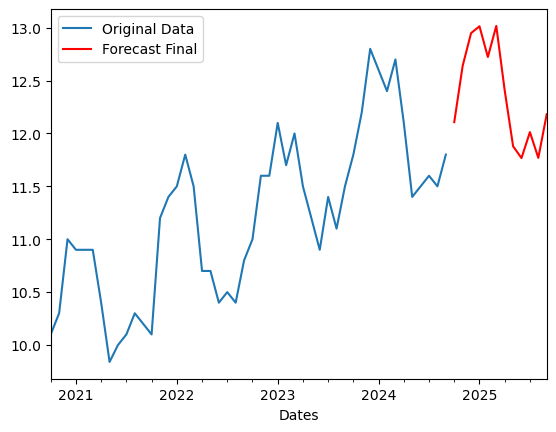

In [63]:
#plot
gas['Prices'].plot(label = 'Original Data')
forecastTol.plot(label = 'Forecast Final', color = 'red')

plt.legend()
plt.show()

In [64]:
forecastTol.index

DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', freq='ME')

In [65]:
def forecastedPrice(date_string):
    try:
        date_obj = pd.to_datetime(date_string)
        
        if date_obj in forecastTol.index:
            return forecastTol[date_obj]
        else:
            return f'{date_string} out of forecasted range'
    except Exception as e:
        return f'Error: {e}'

In [66]:
test = '2024-10-31'
forecastedPrice(test)

12.107143613862307

In [67]:
test2 = '2025-01-31'
forecastedPrice(test2)

13.013227508797142

Injection dates. 
Withdrawal dates.
The prices at which the commodity can be purchased/sold on those dates.
The rate at which the gas can be injected/withdrawn.
The maximum volume that can be stored.
Storage costs.

In [57]:
def contractPrice(injD, wdrlD, pricesIW, rate, maxVol, storageCosts,amt):
    injDate = pd.Timestamp(injD)
    wdrlDate = pd.Timestamp(wdrlD)
    months = (wdrlDate.year - injDate.year) * 12 + wdrlDate.month - injDate.month
    injP = forecastedPrice(injDate)
    wdrlP = forecastedPrice(wdrlDate)
    if amt <= maxVol:
        value = (wdrlP - injP) * amt - rate * amt / 1000000 - storageCosts * months - pricesIW * 2
        return value
    else:
        return "max Volume exceeded"

In [58]:
injD = '2024-10-31'
wdrlD = '2025-01-31'
pricesIW = 50000
rate = 10000
maxVol = 10000000
storageCosts = 100000
amt = 1000000

contractPrice(injD, wdrlD, pricesIW, rate, maxVol, storageCosts,amt)

502393.1233167433